# PC lab 4: Logistic regression for classification

## Introduction

In a binary classification setting, we are interested in assigning an observation $\mathbf{x}$ to one of two possible classes, denoted by $y$. For example, maybe we would like to tell if a patient has a particular disease (y = 1) or not (y = 0), given certain symptoms $\mathbf{x}$. Generally speaking, we want to predict the probability that the class label $y = 1$, conditional on the data that we have observed, $\mathbf{x}$. This probability is also called the *class posterior* or the *class-membership probability*, which we can denote as follows:

\begin{equation}
Pr(Y=1|X) = P(X) = p(y= 1|\mathbf{x})
\end{equation}

The book uses the statistical notation on the left, but the notation with the feature vector $\mathbf{x}$ is more common in machine learning literature. In any case, both notations mean exactly the same. In this PC lab, we will cover one of the most popular classifiers: logistic regression.

Just like linear regression, logistic regression (LR) is a linear model. However, LR does not model the mean of a continuous outcome, but the logarithm of the [odds](https://en.wikipedia.org/wiki/Odds) of the probability $P(X)$:

\begin{equation}
log \frac{P(X)}{1-P(X)} = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p} = \mathbf{w^Tx}
\end{equation}

However, we are really interested in the probability $p$ and not in the odds of p. Therefore, it is common to apply the inverse log-odds transformation on both sides of the equation. This transformation is the **logistic function $\phi(z)$**, hence the name of logistic regression:

\begin{equation}
\phi(z) = \frac{1}{1 + e^{-z}} = \frac{e^{z}}{1+e^{z}}
\end{equation}

Verify for yourself that applying $\phi(z)$ on the log-odds yields $p$.

In other words, we can make predictions for $p$ with logistic regression as follows:

\begin{equation}
P(X) = \phi(w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p})
\end{equation}

If we want to classify a data point $\mathbf{x}$, we can calculate $p$ with LR and simply assign it to class 1 if $p$ exceeds a certain probability threshold. A typical threshold is 0.5. 

<div class="alert alert-success">

<b>EXERCISE: What would happen to our predictions when we would choose a lower threshold, let's say 0.2? How would this affect the accuracy of our predictions? Can you think of a situation where we would want to do this? </b>
</div>

Let's stop for a moment to have a look at what the logistic transformation does:

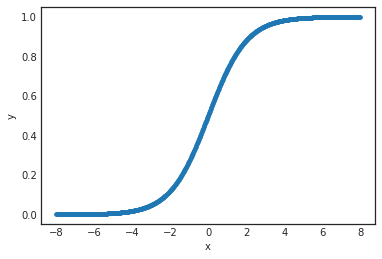

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

x = np.arange(-8,8,0.01) # Generate a range of x values
y = 1/(1+np.exp(-x)) # Calculate the logistic transformation of these x'es

# Plot them
fig, ax = plt.subplots()
ax.scatter(x,y, marker='.');
ax.set_xlabel('x');
ax.set_ylabel('y');

As shown, $\phi$ monotonically maps any number from the real domain to a number in [0,1]. Indeed, this is a desirable property if we want to predict a probability!

## Training a LR model

### Loss function: the cross-entropy loss

Now that we have the logistic regression model to predict the probability of belonging to a certain class, all that remains is the question of how to find the weights of the model on a given set of training data. As always, this is the problem of minimizing a loss function to find an optimal set of weights. Where we used the mean squared error (MSE) for linear regression, we will use the **cross-entropy** loss function for LR. Minimizing the binary cross-entropy loss is equivalent to minimizing the negative log-likelihood of the data under a binomial distribution:

\begin{equation}
l_{log} = \frac{1}{n}\sum\limits_{i=1}^{n}-y_{i}log(p_i)-(1-y_i)log(1-p_i)
\end{equation}

Where $y_i$ is the class of data point $i$ and $p_i$ (or $p(\mathbf{x}_i)$ as in the theory slides) is the class-membership probability predicted by logistic regression for data point $i$. If we look at the cross-entropy loss **for a single data point** $l_{log}^{i}$, we can break it down in two parts:

$\begin{equation}
l_{log}^{i} = 
\begin{cases}
   -log(p_i) & \text{if} \ y_i = 1\\    
   -log(1-p_i) & \text{if} \ y_i = 0
\end{cases}
\end{equation}$

It should be clear that the cross-entropy loss will be larger for smaller values of $p_i$ if $y_i = 1$, and vice versa. Let's visualize the cross-entropy loss for these two cases:

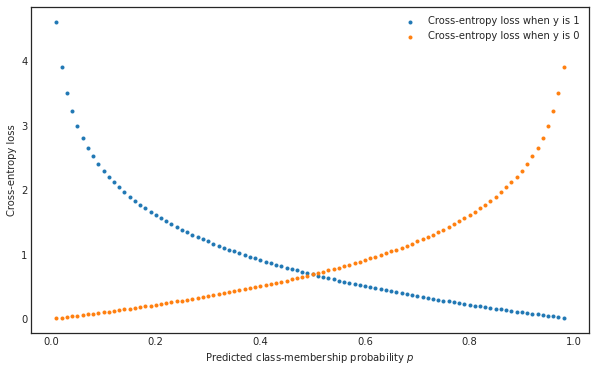

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

p = np.arange(0.01,0.99,0.01) # Generate a range of predicted probabilities between zero and 1
l_0 = -np.log(p)  # cross-entropy loss if y = 0
l_1 = -np.log(1-p)

# Plot them
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(p,l_0, marker='.');
ax.scatter(p, l_1, marker='.');
ax.set_xlabel('Predicted class-membership probability $p$');
ax.set_ylabel('Cross-entropy loss');
ax.legend(['Cross-entropy loss when y is 1', 'Cross-entropy loss when y is 0']);

<div class="alert alert-success">

<b>EXERCISE: Make sure you understand the cross-entropy loss. Verify that it correctly penalizes wrong predictions in both cases. Suppose that we have no information about the data at all, what would be the best guess for p to minimize the cross-entropy loss?</b>
</div>

### Finding the weights with gradient descent

For linear regression, the solutions to the normal equations provide a convenient analytical solution to obtain the optimal set of model weights $\mathbf{w}$ on a set of training data. There is no such solution to find the optimal weights for a logistic regression model, so instead an optimization algorithm such as **gradient descent** is used to train a LR model.

Gradient descent is an iterative optimization algorithm that searches for the optimum of an objective function by making small changes to a set of optimization variables. Gradient descent (and more complex optimization algorithms, but we offer a separate course for that) are widely used in machine learning to find the optimal set of model weights that minimize a certain loss function. Especially when there is no analytical solution for the weights available like for linear regression.

Generally, gradient descent uses the **gradient** of the loss function with respect to the model weights to perform updates to those weights in each iteration. At iteration $k+1$, the algoritm computes the gradient of a loss function $J(\mathbf{w})$ evaluated in the training data. Then, it performs an update to the current parameter values that is relative to the gradient multiplied with the learning rate $\gamma$, which is a constant:

\begin{equation}
\mathbf{w}_{k+1} = \mathbf{w}_{k} - \gamma\nabla{J(\mathbf{w}_{k})}
\end{equation}

Initially, the weights are often initialized with random draws from some distribution. The algorithm continues to do updates, until it converges or until some stopping criterion is reached.

In order to perform gradient descent to find the weights of a logistic regression model, we need to compute the gradient of the loss fuction with respect to the model parameters. Recall that, for a single data point, the cross-entropy loss function was as follows:

\begin{equation}
l_{log}^{i}(\mathbf{w}) = -y_{i}log(p_i)-(1-y_i)log(1-p_i)
\end{equation}

Where $p_i$ is nothing else than the weighted sum of the inputs squashed through the sigmoid function:

\begin{equation}
p_i = \phi(w_{0}x_{0i} + w_{1}x_{1i} + ... + w_{p}x_{pi})
\end{equation}

Before going on, let's first calculate the partial derivative of the sigmoid function:


\begin{equation}
\frac{\partial}{\partial z} \phi(z) = \frac{\partial}{\partial z} \frac{1}{1+e^{-z}} = \frac{e^{-z}}{(1+e^{-z})^2}
\end{equation}

We can rewrite this as follows:

\begin{equation}
\frac{e^{-z}}{(1+e^{-z})^2} = \frac{1 +e^{-z} -1}{(1+e^{-z})^2} = \frac{1}{1+e^{-z}} \Big( 1 - \frac{1}{1+e^{-z}}\Big) = \phi(z)(1 - \phi(z))
\end{equation}

With this result and by applying the chain rule, we can compute the partial derivative of the loss function with respect to the weight $w_j$. We will use the symbol $z$ to denote the weighted sum of the features (i.e., the input for the logistic function) and drop the superscript $i$ for clarity:

\begin{equation}
\frac{\partial l_{log}(\mathbf{w})}{\partial w_j} = \frac{\partial}{\partial w_j} \Big(-ylog(\phi(z))-(1-y)log(1-\phi(z)) \Big) \\ = \Big(  \frac{-y}{\phi(z)} + \frac{1-y}{1-\phi(z)}  \Big)\frac{\partial}{\partial w_j}\phi(z) \\ = \Big(  \frac{-y}{\phi(z)} + \frac{1-y}{1-\phi(z)}  \Big) \phi(z)(1-\phi(z))\frac{\partial}{\partial w_j}z
\end{equation}

Since $z = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p}$, $\frac{\partial}{\partial w_j}z$ is nothing more than $x_j$, so we can rewrite the above as:

\begin{equation}
\frac{\partial l_{log}(\mathbf{w})}{\partial w_j} = \Big( -y(1-\phi(z) + (1-y)\phi(z))\Big)x_j \\ = \big(  -y + \phi(z) \big)x_j = \big( \phi(z) - y \big)x_j
\end{equation}

With this partial derivative of the loss w.r.t $w_j$, we can write the update rule of the gradient descent algorithm for the $j^{th}$ weight:
    
\begin{equation}
w_{j,k+1} = w_{j,k} - \gamma(\phi(z_k)-y)x_{j}
\end{equation}

In other words, the algorithm will each time perform an update to the weight $w_{j}$ that is in proportion to the difference between the predicted probability of class membership in the previous iteration and the actual class. Makes sense! The entire gradient is simply the vector that contains the partial derivatives with respect to the entire weight vector $\mathbf{w}$, and in reality gradient descent acts on $\mathbf{w}$ and not on an individual weight $w_j$. Also, the gradient is typically not calculated for one data point, but evaluated over the entire training data set. 


In practice, software packages such as [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegressionscikit-learn) do this optimization under the hood, so there is no need to implement it manually each time we want to use logistic regression.

## Application: predicting the status of a breast cancer tumor

In the first application of logistic regression, we will use the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). The dataset contains information on the disease status of 569 breast cancer patients: they were either diagnosed with a malign (status M) or with a benign (status B) tumor. 

For each patient, the dataset also contains 30 features that represent statistics of the cell nuclei present in images taken after [fine needle aspirate tissue samples](https://en.wikipedia.org/wiki/Fine-needle_aspiration). These 30 features are the mean, standard deviation and the maximum of 10 measurements on the cell nuclei:
- radius
- texture
- perimeter
- area
- smoothness
- compactness
- concavity
- concave points
- symmetry
- fractal dimension

**Based on these feature of the cell nuclei, we would like to predict whether a patiens has a malign or a benign breast cancer tumor.** 

Let's read in the data:

In [52]:
import pandas as pd

data = pd.read_csv('./wdbc.data', header=None, index_col=0, names=['Patient ID', 'status'] + list(np.arange(1,31,1)))
status = data['status']
data.head()

,status,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Patient ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


First, let's look at the distribution of the disease status:

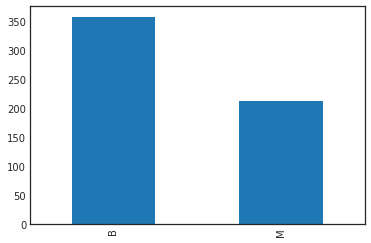

In [53]:
pd.value_counts(data['status']).plot(kind='bar');

There are about 350 benign cases and roughly 200 malign cases. This is a fairly balanced dataset.

<div class="alert alert-success">

<b>EXERCISE: Suppose that the dataset was unbalanced, with 525 B cases and only 25 M cases. Can you think of any problems this could give if we would evaluate the accuracy of our logistic regression predicitions? We will come back to this problem in the next lab.</b>
</div>

In order to perform LR, we will encode the disease status as a binary variable.

In [54]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(status)
encoder.classes_  # 'B' will become class 0, 'M' will become class 1

array(['B', 'M'], dtype=object)

In [55]:
y = encoder.transform(status)
x = data.drop('status', axis=1).values # Drop the disease status from the dataframe, convert to numpy array
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

<div class="alert alert-success">

<b>EXERCISE: Using scikit-learn, split the data in a 80% training and a 20% test set. Fit a logistic regression model and evaluate training and testing accuracy. You should be able to achieve a fairly high accuracy! </b>
</div>

Use [this method](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for train-test splitting and [this implementation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to perform logistic regression. You can use the [score method](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score) to evaluate the accuracy of your model. This method computes the accuracy as follows:

\begin{equation}
score = \frac{\text{Number of correctly classified instances}}{\text{Total number of instances}}
\end{equation}

In [63]:
y_pred = LRmodel.predict(X_train)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # import necessary functions

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
 # split the data in train and test data

LRmodel = LogisticRegression() # Call a logisticregression model from scikit-learn

LRmodel.fit(X_train, y_train) # Fit the model

LRmodel.score(X_train, y_train) # Evaluate the classification accuracy on the training and the testing data


/home/gaeta/miniconda3/envs/SynBio/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9538461538461539

In [57]:
LRmodel.score(X_test, y_test)

0.956140350877193

To get an idea of which features are considered important by the LR model, we can visualize the weights it has learned in a bar plot:

<AxesSubplot:>

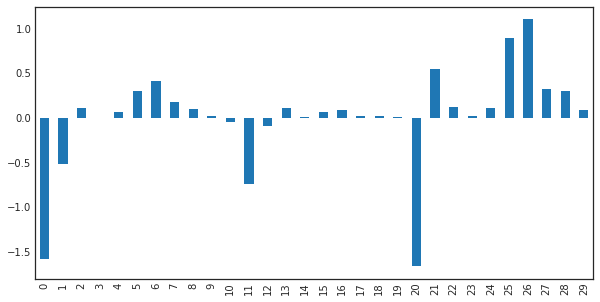

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
pd.Series(LRmodel.coef_.flatten()).plot(ax=ax, kind='bar')

<div class="alert alert-success">

<b>Use your LR model to predict the class probabilities and the classes for the training data. Use the [```predict_proba()```](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method to generate the predicted probabilities. Use the code below to plot the two against each other. Which data points are most likely to be misclassified?</b>
</div>

# P(y=1|x)

In [59]:
predicted_class_probabilities = LRmodel.predict_proba(X_test)[:,1]
predicted_classes = LRmodel.predict(X_test)

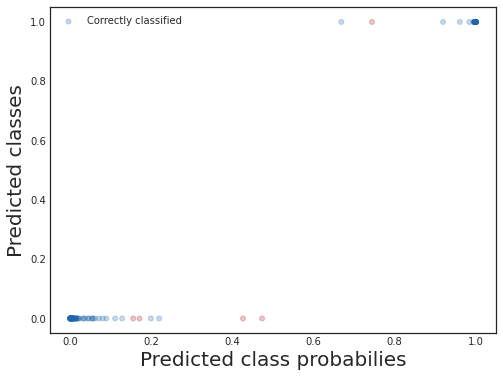

In [61]:
misclassified = predicted_classes !=  y_test
colors = ['#b2182b' if wrong else '#2166ac' for wrong in misclassified ]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(predicted_class_probabilities, predicted_classes, marker='.', s=100, color=colors, alpha=0.25)
ax.set_xlabel('Predicted class probabilies').set_fontsize(20)
ax.set_ylabel('Predicted classes').set_fontsize(20)
ax.legend(['Correctly classified'])

# Multiclass classification

## One-versus-one classification

One-versus-one classification is another approach to a multiclass classification problem. For a K-class problem, the strategy consists of training $\frac{K(K-1)}{2}$ classifiers. Each of these classifiers much learn to distinguish to classes. One the classifiers are trained, a voting scheme is applied to make a prediction for an unseen data point: each classifier has to decide between two possible classes. The final predicted class is that class that gets the largest number of votes. 

## One-versus-all classification

In one-versus-all (OvA) classification, a single classifier is trained per class, with the samples of that class as positive samples and all other samples as negatives. The strategy proceeds as follows for a K-class classification problem:

**Inputs:**
* a classification algorithm L (learner)
* feature matrix $\mathbf{X}$
* label vector y where $y_i \in {1,...,K}$


**Procedure:**
for each k in {1,...,K}:
* construct a new label vector z where $z_i$ is 1 if $y_i$ = k and 0 otherwise
* train L on $\mathbf{X}$ to obtain a classifier $f_k$. The classifier should return class probabilities and not hard labels.

**Returns**
A list of trained classifiers $f_k$ for each  k in {1,...,K}

To make predictions for a new sample $\mathbf{x}$, the $k$ classifiers are applied to $\mathbf{x}$ and the final predicted label is the label that is predicted with the highest confidence (probability):

$\hat{y} = \underset{k \in {1,...,K}}{\mathrm{argmax}} \, f_k(\mathbf{x})$

Let's simulate a toy dataset with three classes and two features, and split it in training and test data:

In [27]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers= [[-2.5, 0], [0, 1], [3.5, -1]], random_state=42)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

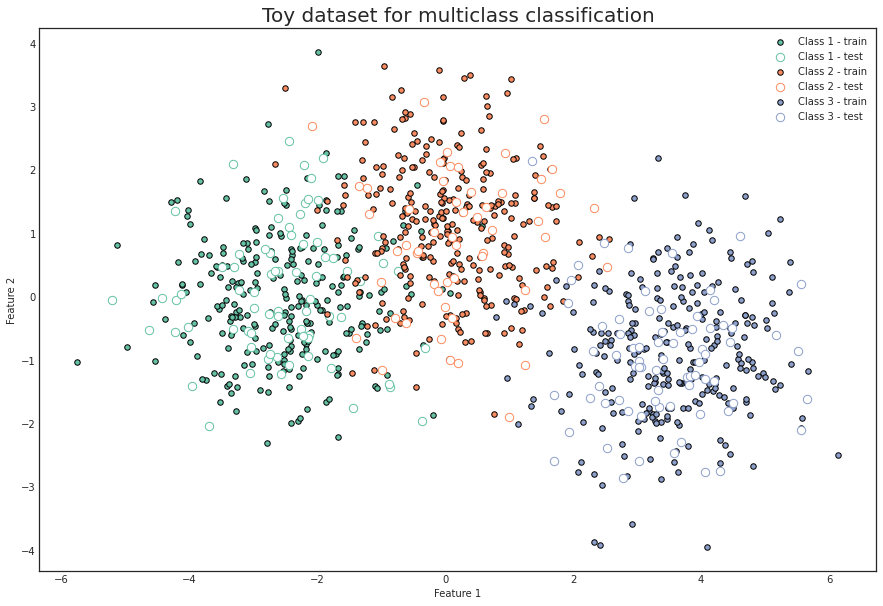

In [28]:
# Make the plot
fig, ax = plt.subplots(figsize=(15,10))
colors=['#66c2a5', '#fc8d62', '#8da0cb']
for i, color in enumerate(colors):
    idx_train = np.where(y_train==i)
    idx_test = np.where(y_test==i)
    plt.scatter(X_train[idx_train,0], X_train[idx_train,1], c=color, edgecolor='black', s=30)
    plt.scatter(X_test[idx_test,0], X_test[idx_test, 1],c='white', edgecolor=color, s=70)
    
ax.legend(['Class 1 - train',
           'Class 1 - test',
           'Class 2 - train',
           'Class 2 - test',
           'Class 3 - train',
           'Class 3 - test']);

ax.set_xlabel('Feature 1');
ax.set_ylabel('Feature 2');
ax.set_title('Toy dataset for multiclass classification').set_fontsize(20);

<div class="alert alert-success">
<b>Implement a one-versus-all loop to tackle this classification problem. Train a list of classifiers on the training data. Make predictions on the test data. You can use the code below to get started. </b>
</div>

In [44]:
# Call three logistic regression models, put them in a list L

L1 = LogisticRegression()
L2 = LogisticRegression()
L3 = LogisticRegression()

L = [L1, L2, L3]

# Train the list of classifiers in one-v-all fashion

for i,l in enumerate(L):
    z_train = (y_train==i)
    l.fit(X_train, z_train)
    
# To make predictions on the test data, append the predicted probabilities of class membership for each classifier to a list

predictions = []
for l in L:
    predictions.append(l.predict_proba(X_test)[:,1])


# For each instance, the final predicted class is the class that was predicted with the highest probability 
predicted_classes = np.array([np.argmax([pred[i] for pred in predictions]) for i in range(len(X_test))])

<div class="alert alert-success">
<b>Run the code below to visualize your predictions. </b>
</div>

In [45]:
classification_accuracy=np.round(np.mean(y_test == predicted_classes)*100,2)

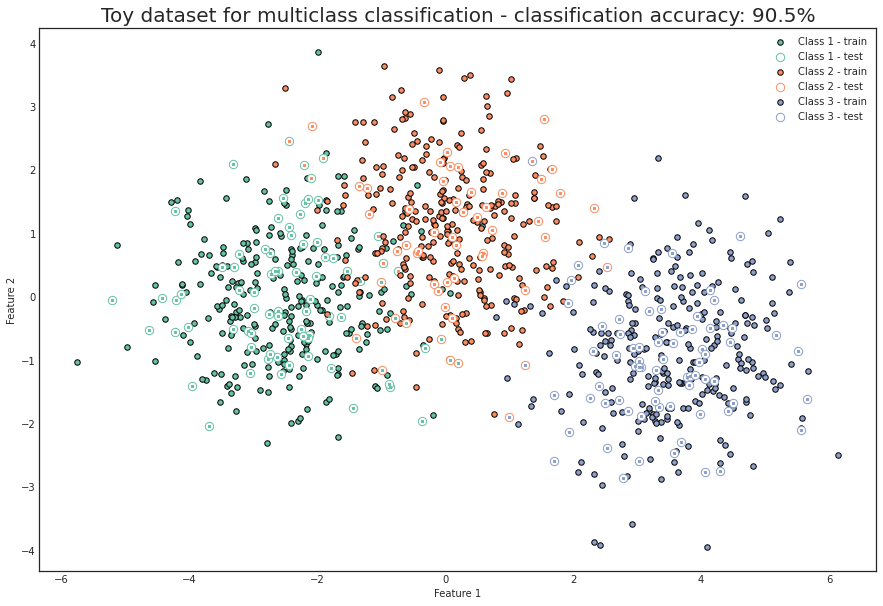

In [46]:
# Visualize the predictions

fig, ax = plt.subplots(figsize=(15,10))
colors=['#66c2a5', '#fc8d62', '#8da0cb']

for i, color in enumerate(colors):
    idx_train = np.where(y_train==i)
    idx_test = np.where(y_test==i)
    
    plt.scatter(X_train[idx_train,0], X_train[idx_train,1], c=color, edgecolor='black', s=30)
    plt.scatter(X_test[idx_test,0], X_test[idx_test, 1],c='white', edgecolor=color, s=70)
        
ax.legend(['Class 1 - train',
           'Class 1 - test',
           'Class 2 - train',
           'Class 2 - test',
           'Class 3 - train',
           'Class 3 - test']);

# add predictions
for i, color in enumerate(colors):
    idx_predicted = np.where(predicted_classes==i)
    plt.scatter(X_test[idx_predicted,0], X_test[idx_predicted,1], c=color, marker='s', s=2)

ax.set_xlabel('Feature 1');
ax.set_ylabel('Feature 2');
ax.set_title('Toy dataset for multiclass classification - classification accuracy: {}%'.format(classification_accuracy)).set_fontsize(20);